In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [5]:
data = pd.read_csv('data/data_cleaned.csv')

In [6]:
data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,days_since_last_logon,inital_amount,EVENT_LABEL,ip_counts,Currency_cad,Currency_eur,Currency_usd
0,3557.0,2196.0,62.0,4346.0,68.0,10447.0,legit,1,1,0,0
1,5454.0,3037.0,54.0,6215.0,67.0,6337.0,legit,1,1,0,0
2,4685.0,3415.0,43.0,6478.0,91.0,11032.0,legit,1,1,0,0
3,2934.0,2613.0,56.0,5475.0,21.0,13205.0,legit,1,1,0,0
4,4127.0,1364.0,62.0,2420.0,91.0,8346.0,legit,1,1,0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       150000 non-null  float64
 1   transaction_amt        150000 non-null  float64
 2   transaction_adj_amt    150000 non-null  float64
 3   historic_velocity      150000 non-null  float64
 4   days_since_last_logon  150000 non-null  float64
 5   inital_amount          150000 non-null  float64
 6   EVENT_LABEL            150000 non-null  object 
 7   ip_counts              150000 non-null  int64  
 8   Currency_cad           150000 non-null  int64  
 9   Currency_eur           150000 non-null  int64  
 10  Currency_usd           150000 non-null  int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 12.6+ MB


In [8]:
#split dataset into features and target
#target is mapped to numeric (0 for fraud, 1 for legit)

X = data.drop('EVENT_LABEL', axis=1)
y = data['EVENT_LABEL'].map({'legit': 1, 'fraud': 0})

In [9]:
data.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,days_since_last_logon,inital_amount,ip_counts,Currency_cad,Currency_eur,Currency_usd
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,4642.444247,2521.478480,54.203040,4702.221347,49.866513,7998.028667,8.824667,0.758340,0.029153,0.211787
std,1159.965133,604.262506,10.066597,1188.021280,29.191524,4045.344431,6.238538,0.428091,0.168237,0.408576
min,1.000000,5.000000,1.000000,50.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000
25%,3821.000000,2104.000000,48.000000,3873.000000,25.000000,4491.000000,4.000000,1.000000,0.000000,0.000000
50%,4666.000000,2544.000000,55.000000,4730.000000,50.000000,8002.000000,8.000000,1.000000,0.000000,0.000000
75%,5475.000000,2951.000000,61.000000,5548.000000,75.000000,11491.000000,13.000000,1.000000,0.000000,0.000000
max,9119.000000,4999.000000,99.000000,9999.000000,100.000000,15000.000000,37.000000,1.000000,1.000000,1.000000


In [10]:
#split into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
#standardize features to have same range

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Modeling

In [13]:
#this is a classification problem
#try logistic regression, random forest / gradient boosting, and XG boost
#grid search CV on hyperparameters
#tree models: try both max_depth and min_samples_leaf hyperparameters
#neural network: grab templates online to use -- evaluate performance compared to trees (not as good for imbalanced dataset)

In [14]:
#import the models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [24]:
#hyperparameter tuning for GB model

params = {'max_depth': [3, 10, 1000], 'min_samples_leaf': [1, 50, 100], 'n_iter_no_change': [5]}

clf = GridSearchCV(GradientBoostingClassifier(), params, cv=5)
clf.fit(X_train_scaled, y_train)
gb_params = clf.best_params_

In [17]:
#hyperparameter tuning for Random Forest model

params = {'max_depth': [3, 10, 15], 'min_samples_leaf': [1, 50, 100], 'n_estimators': [100]}

clf = GridSearchCV(RandomForestClassifier(), params, cv=5)
clf.fit(X_train_scaled, y_train)
rf_params = clf.best_params_

In [23]:
#hyperparameter tuning for XGBoost model

params = {'max_depth': [3, 6, 10], 'min_child_weight': [1, 50, 100], 'n_estimators': [100]}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), params, cv=5)
clf.fit(X_train_scaled, y_train, eval_metric='auc')
xgb_params = clf.best_params_

In [28]:
#create dictionary containing all of the models
#write a function that fits and predicts on all of the models in the dictionary and saves the 
#predicted values into a dataframe and the auc into a dictionary

from sklearn.metrics import roc_auc_score

models = {'rf': RandomForestClassifier(**rf_params), 
          'gbm': GradientBoostingClassifier(**gb_params),
          'lr': LogisticRegression(),
          'xgb': XGBClassifier(**xgb_params)}

pred_probas = pd.DataFrame()
auc_scores = {}

for name, model in models.items():
    local_model = model.fit(X_train_scaled, y_train)
    y_pred_proba = local_model.predict_proba(X_test_scaled)
    pred_probas[name] = y_pred_proba[:,1]
    auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    auc_scores[name] = auc_score

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:05:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
auc_scores

{'rf': 0.9250944052393312,
 'gbm': 0.9274213064806659,
 'lr': 0.91381486034911,
 'xgb': 0.9283315545543623}

In [30]:
xgb_params

{'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}

In [ ]:
#XGBoost model is the best performing with auc = 0.928 as an evaluation metric

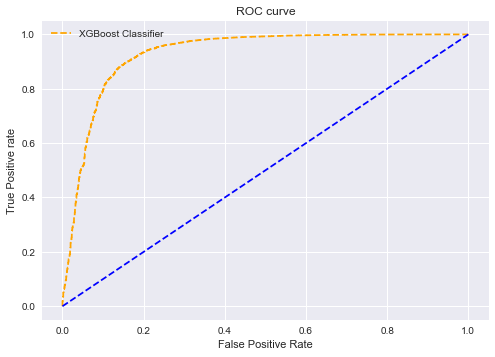

In [35]:
#find roc for xgb model

from sklearn.metrics import roc_curve

fpr, tpr, thresh = roc_curve(y_test, pred_probas['xgb'], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

#plot roc curve
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curve
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBoost Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [13]:
#try neural network

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [14]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    #first layer is same as number of input variables
    model.add(Dense(10, input_dim=10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=500, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train_scaled, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/var/folders/1h/f10mrm6x3sg309bl17kg39r40000gp/T/ipykernel_57267/2346083325.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=500, verbose=1)
2022-01-26 16:30:23.557016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
216/216 [==============================] - 1s 1ms/step - loss: 0.3530 - accuracy: 0.9144
Epoch 2/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1763 - accuracy: 0.9515
Epoch 3/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1375 - accuracy: 0.9575
Epoch 4/100
216/216 [==============================] - 0s 2ms/step - loss: 0.1243 - accuracy: 0.9606
Epoch 5/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1191 - accuracy: 0.9621
Epoch 6/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1168 - accuracy: 0.9628
Epoch 7/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1154 - accuracy: 0.9633
Epoch 8/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1144 - accuracy: 0.9634
Epoch 9/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1137 - accuracy: 0.9637
Epoch 10/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1131 - accura

216/216 [==============================] - 0s 1ms/step - loss: 0.1066 - accuracy: 0.9663
Epoch 61/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9663
Epoch 62/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9663
Epoch 63/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9662
Epoch 64/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9664
Epoch 65/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9663
Epoch 66/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9663
Epoch 67/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9664
Epoch 68/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1064 - accuracy: 0.9663
Epoch 69/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1064 - accuracy: 

216/216 [==============================] - 0s 1ms/step - loss: 0.1101 - accuracy: 0.9649
Epoch 19/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1097 - accuracy: 0.9652
Epoch 20/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1093 - accuracy: 0.9653
Epoch 21/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1089 - accuracy: 0.9655
Epoch 22/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1086 - accuracy: 0.9657
Epoch 23/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1083 - accuracy: 0.9660
Epoch 24/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1081 - accuracy: 0.9660
Epoch 25/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1079 - accuracy: 0.9662
Epoch 26/100
216/216 [==============================] - 0s 2ms/step - loss: 0.1077 - accuracy: 0.9662
Epoch 27/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1075 - accuracy: 

216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9673
Epoch 78/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9674
Epoch 79/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9672
Epoch 80/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1046 - accuracy: 0.9672
Epoch 81/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9673
Epoch 82/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9671
Epoch 83/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9673
Epoch 84/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1046 - accuracy: 0.9672
Epoch 85/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1047 - accuracy: 0.9672
Epoch 86/100
216/216 [==============================] - 0s 1ms/step - loss: 0.1046 - accuracy: 

216/216 [==============================] - 0s 717us/step - loss: 0.1076 - accuracy: 0.9660
Epoch 34/100
216/216 [==============================] - 0s 710us/step - loss: 0.1075 - accuracy: 0.9660
Epoch 35/100
216/216 [==============================] - 0s 712us/step - loss: 0.1075 - accuracy: 0.9659
Epoch 36/100
216/216 [==============================] - 0s 716us/step - loss: 0.1074 - accuracy: 0.9661
Epoch 37/100
216/216 [==============================] - 0s 718us/step - loss: 0.1074 - accuracy: 0.9661
Epoch 38/100
216/216 [==============================] - 0s 719us/step - loss: 0.1073 - accuracy: 0.9662
Epoch 39/100
216/216 [==============================] - 0s 721us/step - loss: 0.1073 - accuracy: 0.9661
Epoch 40/100
216/216 [==============================] - 0s 737us/step - loss: 0.1072 - accuracy: 0.9662
Epoch 41/100
216/216 [==============================] - 0s 729us/step - loss: 0.1072 - accuracy: 0.9661
Epoch 42/100
216/216 [==============================] - 0s 713us/step - loss:

216/216 [==============================] - 0s 759us/step - loss: 0.1059 - accuracy: 0.9666
Epoch 90/100
216/216 [==============================] - 0s 723us/step - loss: 0.1058 - accuracy: 0.9665
Epoch 91/100
216/216 [==============================] - 0s 736us/step - loss: 0.1058 - accuracy: 0.9666
Epoch 92/100
216/216 [==============================] - 0s 731us/step - loss: 0.1057 - accuracy: 0.9665
Epoch 93/100
216/216 [==============================] - 0s 760us/step - loss: 0.1056 - accuracy: 0.9667
Epoch 94/100
216/216 [==============================] - 0s 730us/step - loss: 0.1056 - accuracy: 0.9668
Epoch 95/100
216/216 [==============================] - 0s 717us/step - loss: 0.1055 - accuracy: 0.9667
Epoch 96/100
216/216 [==============================] - 0s 717us/step - loss: 0.1054 - accuracy: 0.9667
Epoch 97/100
216/216 [==============================] - 0s 759us/step - loss: 0.1054 - accuracy: 0.9667
Epoch 98/100
216/216 [==============================] - 0s 742us/step - loss:

216/216 [==============================] - 0s 724us/step - loss: 0.1034 - accuracy: 0.9668
Epoch 68/100
216/216 [==============================] - 0s 733us/step - loss: 0.1034 - accuracy: 0.9669
Epoch 69/100
216/216 [==============================] - 0s 732us/step - loss: 0.1035 - accuracy: 0.9671
Epoch 70/100
216/216 [==============================] - 0s 726us/step - loss: 0.1034 - accuracy: 0.9669
Epoch 71/100
216/216 [==============================] - 0s 722us/step - loss: 0.1034 - accuracy: 0.9669
Epoch 72/100
216/216 [==============================] - 0s 742us/step - loss: 0.1034 - accuracy: 0.9670
Epoch 73/100
216/216 [==============================] - 0s 708us/step - loss: 0.1033 - accuracy: 0.9669
Epoch 74/100
216/216 [==============================] - 0s 738us/step - loss: 0.1033 - accuracy: 0.9671
Epoch 75/100
216/216 [==============================] - 0s 718us/step - loss: 0.1033 - accuracy: 0.9668
Epoch 76/100
216/216 [==============================] - 0s 719us/step - loss:

216/216 [==============================] - 0s 716us/step - loss: 0.1065 - accuracy: 0.9662
Epoch 46/100
216/216 [==============================] - 0s 715us/step - loss: 0.1064 - accuracy: 0.9663
Epoch 47/100
216/216 [==============================] - 0s 727us/step - loss: 0.1064 - accuracy: 0.9663
Epoch 48/100
216/216 [==============================] - 0s 706us/step - loss: 0.1064 - accuracy: 0.9665
Epoch 49/100
216/216 [==============================] - 0s 721us/step - loss: 0.1063 - accuracy: 0.9663
Epoch 50/100
216/216 [==============================] - 0s 715us/step - loss: 0.1063 - accuracy: 0.9663
Epoch 51/100
216/216 [==============================] - 0s 698us/step - loss: 0.1063 - accuracy: 0.9666
Epoch 52/100
216/216 [==============================] - 0s 704us/step - loss: 0.1063 - accuracy: 0.9664
Epoch 53/100
216/216 [==============================] - 0s 722us/step - loss: 0.1062 - accuracy: 0.9664
Epoch 54/100
216/216 [==============================] - 0s 730us/step - loss:

In [ ]:
#plot: test set error rate vs epochs
#neural network validation